In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm
import os
import re

In [3]:
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

In [4]:
from sudachipy import tokenizer
from sudachipy import dictionary
import fugashi
from collections import Counter

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np

In [6]:
import nltk
from nltk.collocations import *

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#генерируем адреса страниц
search_results = ['https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page='+str (i) for i in range(1, 101)]
print (search_results)

['https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=1', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=2', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=3', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=4', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=5', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=6', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=7', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=8', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=9', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=10', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=11', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=12', 'https://news.web.nhk/newsweb/pl/news-nwa-topic-nationwide-0001595?page=13', 'https:

In [8]:
def click_button (driver):
    try:
        Xpath = '//*[@id="erpc-half-modal"]/div/div/div[2]/div/button'
        ss = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, Xpath)))
        ss.click()
        time.sleep (1)
        return True
    except TimeoutException:
        return False

In [ ]:
def find_vid (url, driver):
    '''ищем url новостей с видео'''
    driver.get(url)
    click_button (driver)
    updated_html = driver.page_source
    soup = BeautifulSoup(updated_html, 'html.parser')
    links_with_video = []
    all_links = soup.find_all('a', {'class': 'esl7kn2s i8ir4s4 i8ir4s9 _1yvyrz30'})
    for link in all_links:
        if link.find('div', {'class': 'oqol7i3'}):
            links_with_video.append(link['href'])
    return (links_with_video)

In [ ]:
news_with_video = [] #для поиска всех ссылок на новости с видео в нашей выдаче
driver = webdriver.Chrome()
try:
  for i in tqdm(range(len(search_results))):
    new = find_vid(search_results[i], driver)
    news_with_video = news_with_video + new
finally:
    driver.quit()

In [ ]:
print (f'В нашей выдаче {len(news_with_video)} новостей с видео')

В нашей выдаче 632 новостей с видео


In [ ]:
driver = webdriver.Chrome()
urls1 = find_vid(search_results[0], driver) #для поиска ссылок только со стартовой страницы
driver.quit()
print (urls1)

In [ ]:
urls1 = [] #для поиска ссылок с нескольких первых страниц
driver = webdriver.Chrome()
try:
  for i in range (0,3):
    new = find_vid(search_results[i], driver)
    urls1 = urls1 + new
finally:
    driver.quit()

In [13]:
def getNews(url):
   driver.get(url)
   click_button (driver)
   updated_html = driver.page_source
   soup = BeautifulSoup(updated_html, 'html.parser')
   title = soup.find_all ('meta', {'property' : "og:title"})[0].attrs['content']
   date = soup.find_all('time')[0].get('datetime')
   tags = soup.find_all('div', {'class':['nw--colored _1nidglr8 _1i1d7sh1', 
                                       'nw--border _1nidglrq _1i1d7sh1']})
   for tag in tags:
      for t in tag.find_all():
         t.extract()
   text_list = soup.find_all('p', {'class' : '_1i1d7sh2'})
   text = [i.text for i in text_list]
   final_text = ' '.join(text)
   return title, date, final_text, url

In [ ]:
driver = webdriver.Chrome()
all_news = []
try:
    for i in tqdm(range(len(news_with_video))): #для выгрузки всех новостей с видео
        new = getNews (news_with_video[i])
        all_news.append (new)
finally:
    driver.quit()

In [ ]:
df_all = pd.DataFrame(all_news)
df_all.columns = ['title', 'date', 'text', 'link'] #табличка со всеми новостями

In [14]:
driver = webdriver.Chrome()
news3 = []
try:
    for i in tqdm(range(len(urls1))): #для выгрузки новостей только со стартовой страницы
        new = getNews (urls1[i])
        news3.append (new)
finally:
    driver.quit()

100%|██████████| 26/26 [05:07<00:00, 11.84s/it]


In [ ]:
df_new = pd.DataFrame(news3)
df_new.columns = ['title', 'date', 'text', 'link'] #табличка только с последней порцией новостей

In [17]:
df = pd.read_excel('nhk_news_5jan.xlsx', index_col=0) # подгружаем уже собранный датасет
df = pd.concat ([df_new, df], axis = 0, ignore_index=True) #объединяем его с новой порцией текстов
df.drop_duplicates(inplace = True, ignore_index=True)

In [ ]:
df.head(10)

,title,date,text,link
0,G7と資源国の財務相など 重要鉱物の供給網多角化へ対応で一致 | NHKニュース,2026-01-13T12:34:02+09:00,アメリカで、重要鉱物をテーマにした会議がG7＝主要7か国や資源国の財務相などが参加して開かれ...,https://news.web.nhk/newsweb/na/na-k1001502514...
1,EU 中国からのEV 「最低価格」導入で関税を減免する方針を発表 | NHKニュース,2026-01-13T06:35:22+09:00,EU＝ヨーロッパ連合は、上乗せして関税を課している中国からのEV＝電気自動車について一定の価...,https://news.web.nhk/newsweb/na/na-k1001502497...
2,G7財務相など会議 中国念頭に重要鉱物の供給網の多角化議論か | NHKニュース,2026-01-13T05:39:14+09:00,アメリカで、レアアースなど重要鉱物をテーマにした会議がG7＝主要7か国の財務相などが参加して...,https://news.web.nhk/newsweb/na/na-k1001502478...
3,香港「リンゴ日報」創業者らの裁判 情状酌量検討の審理始まる | NHKニュース,2026-01-12T18:27:50+09:00,中国政府に批判的な論調で知られた香港の新聞「リンゴ日報」の創業者、黎智英氏などが、香港国家安...,https://news.web.nhk/newsweb/na/na-k1001502464...
4,高市首相 春に予定の訪米へ準備加速させる考え | NHKニュース,2026-01-11T14:34:49+09:00,ことし春に予定しているアメリカ訪問をめぐり、高市総理大臣は、11日に放送されたNHKの日曜討...,https://news.web.nhk/newsweb/na/na-k1001502406...
...,...,...,...,...
696,中国 上海 感染者数が最多更新 ゼロコロナ政策見直し求める声 | NHKニュース,2022-04-10T17:55:56+09:00,新型コロナウイルスの感染が拡大している中国の上海では9日、一日に確認された感染者の数が2万5...,https://news.web.nhk/newsweb/na/na-k1001357596...
697,上海 外出制限も感染者3日連続で過去最多 全市民にPCR検査実施 | NHKニュース,2022-04-04T17:13:09+09:00,新型コロナウイルスの感染拡大で段階的に厳しい外出制限が行われている中国最大の経済都市 上海で...,https://news.web.nhk/newsweb/na/na-k1001356671...
698,上海 外出制限で日本人帰国できないおそれ 総領事館が対応要請 | NHKニュース,2022-03-31T12:42:59+09:00,新型コロナウイルスの感染が拡大している中国の上海では厳しい外出制限によって現地に住む日本人が...,https://news.web.nhk/newsweb/na/na-k1001356018...
699,中国 上海 29日の市中感染6000人近くに 外出制限長期化懸念も | NHKニュース,2022-03-30T18:16:47+09:00,新型コロナウイルスの感染が拡大している中国最大の経済都市 上海では29日、市中感染が確認され...,https://news.web.nhk/newsweb/na/na-k1001355962...


In [19]:
df.to_excel ('nhk_news_13jan.xlsx')

In [21]:
df = pd.read_excel ('nhk_news_13jan.xlsx', index_col=0)

In [22]:
stop_words_fu = ['為る', '居る', '言う', '成る', 'つく', '巡る', '事', '物', '有る', '因る', '対する', '上', '中', '間', 
                 '際', '他', '内', '為', '無い', '述べる', '出来る', '行う', '行く', '来る', '見る', '日', '月', '月日', 
                 '今月', '先月', '年', '年間', '去年', '今年', '今後', '今回', '以降', 'パーセント-percent', '凡そ', '兆',
                 '億', '万', '側', '人', '前', '後', '共', '一方', '機', 'こう', '更に', '関する', 'どう', '午前', '午後']
stop_words_su = ['為る', '居る', '言う', '成る', 'つく', '巡る', '有る', 'よる', 'こと', '物', '日', '今回', '月', '今月', 
                '先月', '月日', '年', '去年', '今年', '年間', '午前', '午後', '述べる', '行う', '行く', '来る', '出来る', 
                '見る', '対する', 'とも', '上', '際', '中', '他', '無い', '為', '凡そ', '%', '側', '人', '前', '後', '今後', 
                '以降', '一方', '兆', '億', '万', '機', '間', 'うち', 'こう', '更に', '関する', 'どう']

In [276]:
print (f'В списке стоп-слов для токенизатора sudachi {len(stop_words_su)} слов')
print (f'В списке стоп-слов для токенизатора fugashi {len(stop_words_fu)} слов')

В списке стоп-слов для токенизатора sudachi 55 слов
В списке стоп-слов для токенизатора fugashi 55 слов


In [291]:
common = set(stop_words_su) & set(stop_words_fu)
print (f'У токенизатора fugashi есть такие леммы: {set(stop_words_fu) - common}')
print (f'В токенизаторе sudachi они выглядят вот так: {set(stop_words_su) - common}')

У токенизатора fugashi есть такие леммы: {'事', '内', '共', 'パーセント-percent', '因る'}
В токенизаторе sudachi они выглядят вот так: {'とも', 'よる', 'こと', '%', 'うち'}


In [23]:
def tokenize_su (text):
    text_without_punct = re.sub(r'[\n\d+\s%「」『』“”、。]', '', text)
    tokenizer_obj = dictionary.Dictionary().create()
    mode = tokenizer.Tokenizer.SplitMode.C
    tokenized = tokenizer_obj.tokenize(text_without_punct, mode)
    allowed_pos = [
    '名詞',       # Существительное (включая代名詞 - местоимение)
    '動詞',       # Глагол
    '形容詞',     # Прилагательное
    '副詞'        # Наречие
    ]
    meaningful_tokens = []
    for token in tokenized:
        if token.part_of_speech()[0] in allowed_pos:
            meaningful_tokens.append(token.normalized_form())
    stop_words = stop_words_su
    clean_tokens = []
    for token in meaningful_tokens:
        if token not in stop_words:
            clean_tokens.append(token)
    return clean_tokens

In [24]:
df['tokens'] = df['text'].apply(tokenize_su)

In [26]:
df ['frequent tokens'] = df['tokens'].apply(lambda x: Counter(x).most_common(10))

In [ ]:
df.head(10)

,title,date,text,link,tokens,frequent tokens
0,G7と資源国の財務相など 重要鉱物の供給網多角化へ対応で一致 | NHKニュース,2026-01-13T12:34:02+09:00,アメリカで、重要鉱物をテーマにした会議がG7＝主要7か国や資源国の財務相などが参加して開かれ...,https://news.web.nhk/newsweb/na/na-k1001502514...,"[アメリカ, 鉱物, テーマ, 会議, g, 国, 資源国, 財務相, 参加, 開く, 中国...","[(鉱物, 6), (会議, 4), (中国, 4), (日本, 4), (アメリカ, 3)..."
1,EU 中国からのEV 「最低価格」導入で関税を減免する方針を発表 | NHKニュース,2026-01-13T06:35:22+09:00,EU＝ヨーロッパ連合は、上乗せして関税を課している中国からのEV＝電気自動車について一定の価...,https://news.web.nhk/newsweb/na/na-k1001502497...,"[EU, ヨーロッパ連合, 上乗せ, 関税, 課する, 中国, EV, 電気, 自動車, 一...","[(中国, 11), (EU, 10), (関税, 8), (上乗せ, 4), (減免, 4..."
2,G7財務相など会議 中国念頭に重要鉱物の供給網の多角化議論か | NHKニュース,2026-01-13T05:39:14+09:00,アメリカで、レアアースなど重要鉱物をテーマにした会議がG7＝主要7か国の財務相などが参加して...,https://news.web.nhk/newsweb/na/na-k1001502478...,"[アメリカ, レアアース, 鉱物, テーマ, 会議, g, 国, 財務相, 参加, 開く, ...","[(中国, 5), (アメリカ, 4), (鉱物, 4), (日本, 4), (レアアース,..."
3,香港「リンゴ日報」創業者らの裁判 情状酌量検討の審理始まる | NHKニュース,2026-01-12T18:27:50+09:00,中国政府に批判的な論調で知られた香港の新聞「リンゴ日報」の創業者、黎智英氏などが、香港国家安...,https://news.web.nhk/newsweb/na/na-k1001502464...,"[中国, 政府, 批判的, 論調, 知る, 香港, 新聞, 林檎, 日報, 創業者, 黎智,...","[(黎, 6), (香港, 5), (中国, 4), (審理, 4), (政府, 3), (..."
4,高市首相 春に予定の訪米へ準備加速させる考え | NHKニュース,2026-01-11T14:34:49+09:00,ことし春に予定しているアメリカ訪問をめぐり、高市総理大臣は、11日に放送されたNHKの日曜討...,https://news.web.nhk/newsweb/na/na-k1001502406...,"[春, 予定, アメリカ, 訪問, 市, 総理大臣, 放送, NHK, 日曜, 討論, トラ...","[(訪問, 3), (日米, 3), (確り, 3), (春, 2), (予定, 2), (..."
...,...,...,...,...,...,...
696,中国 上海 感染者数が最多更新 ゼロコロナ政策見直し求める声 | NHKニュース,2022-04-10T17:55:56+09:00,新型コロナウイルスの感染が拡大している中国の上海では9日、一日に確認された感染者の数が2万5...,https://news.web.nhk/newsweb/na/na-k1001357596...,"[新型コロナウイルス, 感染, 拡大, 中国, 上海, 一日, 確認, 感染者, 数, 万人...","[(上海, 5), (外出, 5), (政策, 5), (感染, 4), (確認, 4), ..."
697,上海 外出制限も感染者3日連続で過去最多 全市民にPCR検査実施 | NHKニュース,2022-04-04T17:13:09+09:00,新型コロナウイルスの感染拡大で段階的に厳しい外出制限が行われている中国最大の経済都市 上海で...,https://news.web.nhk/newsweb/na/na-k1001356671...,"[新型コロナウイルス, 感染, 拡大, 段階的, 厳しい, 外出, 制限, 中国, 最大, ...","[(制限, 12), (外出, 11), (上海, 11), (感染, 8), (地域, 7..."
698,上海 外出制限で日本人帰国できないおそれ 総領事館が対応要請 | NHKニュース,2022-03-31T12:42:59+09:00,新型コロナウイルスの感染が拡大している中国の上海では厳しい外出制限によって現地に住む日本人が...,https://news.web.nhk/newsweb/na/na-k1001356018...,"[新型コロナウイルス, 感染, 拡大, 中国, 上海, 厳しい, 外出, 制限, 現地, 住...","[(上海, 9), (空港, 4), (出る, 4), (日本, 4), (総領事館, 4)..."
699,中国 上海 29日の市中感染6000人近くに 外出制限長期化懸念も | NHKニュース,2022-03-30T18:16:47+09:00,新型コロナウイルスの感染が拡大している中国最大の経済都市 上海では29日、市中感染が確認され...,https://news.web.nhk/newsweb/na/na-k1001355962...,"[新型コロナウイルス, 感染, 拡大, 中国, 最大, 経済, 都市, 上海, 市, 感染,...","[(上海, 8), (感染, 6), (外出, 6), (制限, 5), (拡大, 3), ..."


In [28]:
all_tokens = sum (df['tokens'], [])

In [29]:
print (f'Используя наш основной токенизатор sudachi, мы найдем в корпусе {len(all_tokens)} токенов и {len(set(all_tokens))} уникальных токенов')

Используя наш основной токенизатор sudachi, мы найдем в корпусе 127339 токенов и 9587 уникальных токенов


In [30]:
print (Counter(all_tokens).most_common(100))

[('中国', 4021), ('日本', 1552), ('アメリカ', 1538), ('政府', 765), ('示す', 727), ('会談', 695), ('関税', 656), ('ロシア', 656), ('台湾', 609), ('発表', 598), ('関係', 582), ('経済', 521), ('大統領', 469), ('総理大臣', 463), ('措置', 462), ('トランプ大統領', 455), ('強化', 454), ('首脳', 452), ('ウクライナ', 411), ('貿易', 406), ('企業', 405), ('国', 397), ('安全', 390), ('協力', 384), ('求める', 378), ('確認', 369), ('影響', 368), ('対応', 362), ('国家', 357), ('受ける', 350), ('向ける', 346), ('世界', 339), ('感染', 331), ('考え', 325), ('輸出', 324), ('拡大', 317), ('会見', 304), ('進める', 301), ('地域', 289), ('国際', 288), ('協議', 286), ('続く', 286), ('軍事', 285), ('輸入', 284), ('主席', 281), ('記者', 281), ('政策', 279), ('話す', 272), ('必要', 268), ('開く', 267), ('取る', 267), ('伝える', 263), ('懸念', 261), ('訪問', 258), ('保障', 257), ('両国', 257), ('連携', 254), ('訪れる', 254), ('強調', 254), ('問題', 252), ('追加', 251), ('トランプ政権', 247), ('会議', 241), ('活動', 240), ('当局', 235), ('対策', 234), ('アジア', 233), ('指摘', 226), ('軍', 222), ('外務省', 222), ('続ける', 221), ('情勢', 218), ('各国', 213), ('支援', 211), ('強い', 20

In [17]:
tokens_by_article = df['tokens']

In [18]:
def news_tokenizer (text):
    return (text)

In [19]:
tfidf = TfidfVectorizer(
    tokenizer=news_tokenizer,
    preprocessor=news_tokenizer,
    token_pattern=None  # Обязательно в новых версиях sklearn при использовании кастомного токенизатора
)

X = tfidf.fit_transform(tokens_by_article)

In [35]:
X.shape

(701, 9587)

In [36]:
feature_names = np.array(tfidf.get_feature_names_out())
top_tfidf = []
for row in X:
    # Превращаем строку разреженной матрицы в массив
    row_data = row.toarray().flatten()
    # Находим индексы топ-N значений
    top_indices = np.argsort(row_data)[-10:][::-1]
    # Извлекаем слова, вес которых больше 0
    top_words = [feature_names[i] for i in top_indices if row_data[i] > 0]
    top_tfidf.append(top_words)

In [37]:
df['top 10 tf-idf'] = top_tfidf

In [38]:
df.head(20)

,title,date,text,link,tokens,frequent tokens,top 10 tf-idf
0,G7と資源国の財務相など 重要鉱物の供給網多角化へ対応で一致 | NHKニュース,2026-01-13T12:34:02+09:00,アメリカで、重要鉱物をテーマにした会議がG7＝主要7か国や資源国の財務相などが参加して開かれ...,https://news.web.nhk/newsweb/na/na-k1001502514...,"[アメリカ, 鉱物, テーマ, 会議, g, 国, 資源国, 財務相, 参加, 開く, 中国...","[(鉱物, 6), (会議, 4), (中国, 4), (日本, 4), (アメリカ, 3)...","[鉱物, 片山, 資源国, 会議, 圧倒的, 財務相, 多角化, シェア, 危機感, テーマ]"
1,EU 中国からのEV 「最低価格」導入で関税を減免する方針を発表 | NHKニュース,2026-01-13T06:35:22+09:00,EU＝ヨーロッパ連合は、上乗せして関税を課している中国からのEV＝電気自動車について一定の価...,https://news.web.nhk/newsweb/na/na-k1001502497...,"[EU, ヨーロッパ連合, 上乗せ, 関税, 課する, 中国, EV, 電気, 自動車, 一...","[(中国, 11), (EU, 10), (関税, 8), (上乗せ, 4), (減免, 4...","[EU, 減免, 関税, 最低価格, 上乗せ, EV, 補助金, 中国, 場合, 貿易]"
2,G7財務相など会議 中国念頭に重要鉱物の供給網の多角化議論か | NHKニュース,2026-01-13T05:39:14+09:00,アメリカで、レアアースなど重要鉱物をテーマにした会議がG7＝主要7か国の財務相などが参加して...,https://news.web.nhk/newsweb/na/na-k1001502478...,"[アメリカ, レアアース, 鉱物, テーマ, 会議, g, 国, 財務相, 参加, 開く, ...","[(中国, 5), (アメリカ, 4), (鉱物, 4), (日本, 4), (レアアース,...","[片山, 鉱物, レアアース, 圧倒的, 財務相, 多角化, シェア, 会議, テーマ, 供給]"
3,香港「リンゴ日報」創業者らの裁判 情状酌量検討の審理始まる | NHKニュース,2026-01-12T18:27:50+09:00,中国政府に批判的な論調で知られた香港の新聞「リンゴ日報」の創業者、黎智英氏などが、香港国家安...,https://news.web.nhk/newsweb/na/na-k1001502464...,"[中国, 政府, 批判的, 論調, 知る, 香港, 新聞, 林檎, 日報, 創業者, 黎智,...","[(黎, 6), (香港, 5), (中国, 4), (審理, 4), (政府, 3), (...","[黎, 審理, 香港, 情状酌量, 量刑, 黎智, 健康状態, 論調, 林檎, 創業者]"
4,高市首相 春に予定の訪米へ準備加速させる考え | NHKニュース,2026-01-11T14:34:49+09:00,ことし春に予定しているアメリカ訪問をめぐり、高市総理大臣は、11日に放送されたNHKの日曜討...,https://news.web.nhk/newsweb/na/na-k1001502406...,"[春, 予定, アメリカ, 訪問, 市, 総理大臣, 放送, NHK, 日曜, 討論, トラ...","[(訪問, 3), (日米, 3), (確り, 3), (春, 2), (予定, 2), (...","[確り, 日米, 春, 訪問, 準備, 心意気, 相手方, 分かち合う, 外交, 切り開く]"
5,“防衛装備品の海外への移転”「肯定的」68％ 内閣府調査 | NHKニュース,2026-01-10T11:08:52+09:00,内閣府の世論調査で、防衛装備品の海外への移転を一定のルールに基づきながら進めることの是非を尋...,https://news.web.nhk/newsweb/na/na-k1001502353...,"[内閣府, 世論, 調査, 防衛, 装備, 海外, 移転, 一定, ルール, 基づく, 進め...","[(防衛, 5), (装備, 4), (移転, 4), (調査, 3), (尋ねる, 3),...","[移転, 肯定的, 防衛, 装備, 尋ねる, 前回, ポイント, 内閣府, 世論, 是非]"
6,経団連会長と経産相が会談 賃上げの勢い持続の環境整備で連携 | NHKニュース,2026-01-09T13:39:21+09:00,経団連の筒井会長と赤澤経済産業大臣が9日会談し、賃上げの勢いを持続させるための環境整備に官民...,https://news.web.nhk/newsweb/na/na-k1001502263...,"[経団連, 筒井, 会長, 赤澤, 経済産業大臣, 会談, 賃上げ, 勢い, 持続, 環境,...","[(経団連, 4), (筒井, 4), (会長, 4), (赤澤, 4), (経済産業大臣,...","[赤澤, 筒井, 経団連, 賃上げ, 会長, 経済産業大臣, 官民, 取り組む, 勢い, 持続]"
7,米エネルギー長官 ベネズエラと中国の原油取り引き 容認の考え | NHKニュース,2026-01-09T09:07:35+09:00,アメリカのライトエネルギー長官はベネズエラと中国の原油の取り引きについて、アメリカがベネズエ...,https://news.web.nhk/newsweb/na/na-k1001502237...,"[アメリカ, ライト, エネルギー, 長官, ベネズエラ, 中国, 原油, 取り引き, アメ...","[(ベネズエラ, 9), (中国, 6), (アメリカ, 5), (原油, 4), (示す,...","[ベネズエラ, 原油, ライト, 限り, 取り引き, 容認, 長官, 影響力, アメリカ, ..."
8,中国に輸出の日本酒など 通関手続きに遅れ 経済的圧力の一環か | NHKニュース,2026-01-08T22:33:23+09:00,いわゆる「台湾有事」をめぐる高市総理大臣の国会答弁以降、日本から中国に輸出された日本酒や食品...,https://news.web.nhk/newsweb/na/na-k1001502225...,"[台湾, 有事, 高市, 総理大臣, 国会, 答弁, 日本, 中国, 輸出, 日本酒, 食品...","[(日本, 5), (中国, 5), (手続き, 5), (輸出, 4), (日本酒, 4)...","[日本酒, 遅れ, 通関, 手続き, 輸出, 答弁, 国会, 食品, 一環, 経済面]"
9,“アジア最大の犯罪組織の一つ” カンボジア企業の3人を拘束 | NHKニュース,2026-01-08T18:24:19+09:00,カンボジア政府は、国際的なオンライン詐欺を繰り返し、アメリカ当局から「アジア最大の国際犯罪組...,https://news.web.nhk/newsweb/na/na-k1001502202...,"[カンボジア, 政府, 国際的, オンライン, 詐欺, 繰り返す, アメリカ, 当局, アジ...","[(カンボジア, 8), (国際的, 4), (中国, 4), (政府, 3), (詐欺, ...","[カンボジア, チェン, 詐欺, 国籍, 国際的, 会長, 複合, 犯罪, 組織, グループ]"


In [35]:
df.to_excel('nhk_news_13jan_tokens_tfidf.xlsx')

In [31]:
def tokenize_fu (text):
    text_without_punct = re.sub(r'[\n\d+\s%「」『』“”、。]', '', text)
    tagger = fugashi.Tagger()
    tokenized = tagger (text_without_punct)
    allowed_pos = [
    '名詞',       # Существительное (включая代名詞 - местоимение)
    '動詞',       # Глагол
    '形容詞',     # Прилагательное
    '副詞'       # Наречие
    ]
    meaningful_tokens = []
    for word in tokenized:
        if word.feature.pos1 in allowed_pos:
            meaningful_tokens.append(word.feature.lemma)
    stop_words = stop_words_fu
    clean_tokens = []
    for token in meaningful_tokens:
        if token not in stop_words and token is not None:
            clean_tokens.append(token)
    return clean_tokens

In [32]:
all_texts = df['text'].str.cat()
all_tokenized = tokenize_fu (all_texts)

In [33]:
print (f'Токенизатор fugashi найдет в корпусе {len (all_tokenized)} токенов и {len (set(all_tokenized))} уникальных токенов')

Токенизатор fugashi найдет в корпусе 131180 токенов и 7886 уникальных токенов


In [34]:
print (Counter (all_tokenized).most_common(100))

[('中国', 4131), ('日本', 1891), ('アメリカ-America', 1617), ('大統領', 939), ('トランプ-trump', 804), ('政府', 769), ('示す', 727), ('関係', 720), ('大臣', 707), ('会談', 695), ('経済', 676), ('関税', 673), ('ロシア-Rossiya', 656), ('タイワン', 610), ('発表', 603), ('総理', 483), ('感染', 472), ('措置', 463), ('強化', 454), ('企業', 454), ('安全', 454), ('首脳', 452), ('貿易', 435), ('影響', 417), ('ウクライナ-Ukraina', 411), ('協力', 407), ('国際', 404), ('国', 398), ('世界', 386), ('政権', 381), ('求める', 378), ('輸入', 376), ('確認', 372), ('軍事', 370), ('対応', 369), ('記者', 369), ('輸出', 364), ('国家', 364), ('受ける', 350), ('向ける', 346), ('コロナ-corona', 327), ('外務', 326), ('考え', 325), ('拡大', 317), ('地域', 306), ('会見', 304), ('進める', 302), ('訪問', 298), ('必要', 293), ('協議', 292), ('軍', 292), ('主席', 289), ('保障', 288), ('続く', 286), ('政策', 279), ('防衛', 278), ('アジア-Asia', 277), ('両国', 276), ('取る', 275), ('会議', 273), ('話す', 272), ('開く', 267), ('当局', 265), ('問題', 263), ('伝える', 263), ('懸念', 261), ('連携', 258), ('追加', 256), ('訪れる', 254), ('強調', 254), ('活動', 244), ('対策', 234), (

In [40]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

bigram_finder = BigramCollocationFinder.from_words(all_tokenized)
student = bigram_finder.score_ngrams(bigram_measures.student_t)

bigramstudent_df = pd.DataFrame([' '.join([bigram[0][0], bigram[0][1]]), bigram[0][0], bigram[0][1], bigram[1]] for bigram in student)
bigramstudent_df.columns = ['bigram', 'word_1', 'word_2', 't-score']
bigramstudent_df.sort_values(by='t-score', inplace=True, ascending=False, ignore_index=True)
bigramstudent_df.head(45)

,bigram,word_1,word_2,t-score
0,総理 大臣,総理,大臣,21.744146
1,トランプ-trump 大統領,トランプ-trump,大統領,21.226433
2,安全 保障,安全,保障,16.733501
3,トランプ-trump 政権,トランプ-trump,政権,16.166330
4,記者 会見,記者,会見,15.565755
5,追加 関税,追加,関税,14.912442
6,中国 政府,中国,政府,14.824689
7,首脳 会談,首脳,会談,14.326125
8,国家 主席,国家,主席,13.689396
9,タイラ 国家,タイラ,国家,13.378766


In [ ]:
keywords = ['中国', 'タイワン', '安全', '経済', '強化', '軍事'] # перевод: Китай, Тайвань, безопасность, экономика, усиление, военный

In [43]:
for word in keywords:
    bigram_win_finder = BigramCollocationFinder.from_words(all_tokenized, window_size=5)
    bigram_win_finder.apply_ngram_filter(lambda w1, w2: word not in (w1, w2))
    top_collocations = bigram_win_finder.score_ngrams(bigram_measures.likelihood_ratio)[:20]
    print(f"Топ-20 коллокаций для слова '{word}':")
    for i, (collocation, score) in enumerate(top_collocations, 1):
        print(f"{i}. {' '.join(collocation)} | LogLikelihoodRatio: {score:.4f}")
    print()

Топ-20 коллокаций для слова '中国':
1. 中国 政府 | LogLikelihoodRatio: 75.2538
2. 中国 外務 | LogLikelihoodRatio: 54.6650
3. 中国 軍 | LogLikelihoodRatio: 51.1900
4. 中国 中国 | LogLikelihoodRatio: 47.7989
5. 中国 国家 | LogLikelihoodRatio: 47.5151
6. 中国 タイラ | LogLikelihoodRatio: 39.8057
7. 中国 局 | LogLikelihoodRatio: 37.7608
8. 中国 報道 | LogLikelihoodRatio: 36.9533
9. 中国 追加 | LogLikelihoodRatio: 36.3858
10. 中国 念頭 | LogLikelihoodRatio: 35.7358
11. 中国 大統領 | LogLikelihoodRatio: 27.1598
12. 中国 主席 | LogLikelihoodRatio: 26.5317
13. 中国 共産 | LogLikelihoodRatio: 23.5215
14. 中国 輸入 | LogLikelihoodRatio: 22.4715
15. 中国 統計 | LogLikelihoodRatio: 21.6987
16. 中国 輸出 | LogLikelihoodRatio: 19.2357
17. 中国 大臣 | LogLikelihoodRatio: 18.6255
18. 強める 中国 | LogLikelihoodRatio: 18.4630
19. 中国 剣 | LogLikelihoodRatio: 18.2752
20. 中国 記者 | LogLikelihoodRatio: 16.6757

Топ-20 коллокаций для слова 'タイワン':
1. タイワン 有事 | LogLikelihoodRatio: 106.9965
2. タイワン 海峡 | LogLikelihoodRatio: 91.0989
3. タイワン 周辺 | LogLikelihoodRatio: 64.1495
4. タイワン 国会 | L

In [41]:
df['frequent_bigrams'] = df['tokens'].apply(lambda x: BigramCollocationFinder.from_words(x).score_ngrams(nltk.collocations.BigramAssocMeasures().student_t)[:10])
df.head(10)

,title,date,text,link,tokens,frequent tokens,top 10 tf-idf,frequent_bigrams
0,G7と資源国の財務相など 重要鉱物の供給網多角化へ対応で一致 | NHKニュース,2026-01-13T12:34:02+09:00,アメリカで、重要鉱物をテーマにした会議がG7＝主要7か国や資源国の財務相などが参加して開かれ...,https://news.web.nhk/newsweb/na/na-k1001502514...,"[アメリカ, 鉱物, テーマ, 会議, g, 国, 資源国, 財務相, 参加, 開く, 中国...","[(鉱物, 6), (会議, 4), (中国, 4), (日本, 4), (アメリカ, 3)...","[鉱物, 片山, 資源国, 会議, 圧倒的, 財務相, 多角化, シェア, 危機感, テーマ]","[((シェア, 占める), 1.3894027981209354), ((供給, 多角化),..."
1,EU 中国からのEV 「最低価格」導入で関税を減免する方針を発表 | NHKニュース,2026-01-13T06:35:22+09:00,EU＝ヨーロッパ連合は、上乗せして関税を課している中国からのEV＝電気自動車について一定の価...,https://news.web.nhk/newsweb/na/na-k1001502497...,"[EU, ヨーロッパ連合, 上乗せ, 関税, 課する, 中国, EV, 電気, 自動車, 一...","[(中国, 11), (EU, 10), (関税, 8), (上乗せ, 4), (減免, 4...","[EU, 減免, 関税, 最低価格, 上乗せ, EV, 補助金, 中国, 場合, 貿易]","[((関税, 減免), 1.6072183169332825), ((一定, 価格), 1...."
2,G7財務相など会議 中国念頭に重要鉱物の供給網の多角化議論か | NHKニュース,2026-01-13T05:39:14+09:00,アメリカで、レアアースなど重要鉱物をテーマにした会議がG7＝主要7か国の財務相などが参加して...,https://news.web.nhk/newsweb/na/na-k1001502478...,"[アメリカ, レアアース, 鉱物, テーマ, 会議, g, 国, 財務相, 参加, 開く, ...","[(中国, 5), (アメリカ, 4), (鉱物, 4), (日本, 4), (レアアース,...","[片山, 鉱物, レアアース, 圧倒的, 財務相, 多角化, シェア, 会議, テーマ, 供給]","[((シェア, 占める), 1.3898305699183864), ((供給, 多角化),..."
3,香港「リンゴ日報」創業者らの裁判 情状酌量検討の審理始まる | NHKニュース,2026-01-12T18:27:50+09:00,中国政府に批判的な論調で知られた香港の新聞「リンゴ日報」の創業者、黎智英氏などが、香港国家安...,https://news.web.nhk/newsweb/na/na-k1001502464...,"[中国, 政府, 批判的, 論調, 知る, 香港, 新聞, 林檎, 日報, 創業者, 黎智,...","[(黎, 6), (香港, 5), (中国, 4), (審理, 4), (政府, 3), (...","[黎, 審理, 香港, 情状酌量, 量刑, 黎智, 健康状態, 論調, 林檎, 創業者]","[((国家, 安全), 1.6917705562300662), ((中国, 政府), 1...."
4,高市首相 春に予定の訪米へ準備加速させる考え | NHKニュース,2026-01-11T14:34:49+09:00,ことし春に予定しているアメリカ訪問をめぐり、高市総理大臣は、11日に放送されたNHKの日曜討...,https://news.web.nhk/newsweb/na/na-k1001502406...,"[春, 予定, アメリカ, 訪問, 市, 総理大臣, 放送, NHK, 日曜, 討論, トラ...","[(訪問, 3), (日米, 3), (確り, 3), (春, 2), (予定, 2), (...","[確り, 日米, 春, 訪問, 準備, 心意気, 相手方, 分かち合う, 外交, 切り開く]","[((予定, アメリカ), 1.3902438409769409), ((外交, 経済), ..."
5,“防衛装備品の海外への移転”「肯定的」68％ 内閣府調査 | NHKニュース,2026-01-10T11:08:52+09:00,内閣府の世論調査で、防衛装備品の海外への移転を一定のルールに基づきながら進めることの是非を尋...,https://news.web.nhk/newsweb/na/na-k1001502353...,"[内閣府, 世論, 調査, 防衛, 装備, 海外, 移転, 一定, ルール, 基づく, 進め...","[(防衛, 5), (装備, 4), (移転, 4), (調査, 3), (尋ねる, 3),...","[移転, 肯定的, 防衛, 装備, 尋ねる, 前回, ポイント, 内閣府, 世論, 是非]","[((尋ねる, 所), 1.6883856611595778), ((防衛, 装備), 1...."
6,経団連会長と経産相が会談 賃上げの勢い持続の環境整備で連携 | NHKニュース,2026-01-09T13:39:21+09:00,経団連の筒井会長と赤澤経済産業大臣が9日会談し、賃上げの勢いを持続させるための環境整備に官民...,https://news.web.nhk/newsweb/na/na-k1001502263...,"[経団連, 筒井, 会長, 赤澤, 経済産業大臣, 会談, 賃上げ, 勢い, 持続, 環境,...","[(経団連, 4), (筒井, 4), (会長, 4), (赤澤, 4), (経済産業大臣,...","[赤澤, 筒井, 経団連, 賃上げ, 会長, 経済産業大臣, 官民, 取り組む, 勢い, 持続]","[((筒井, 会長), 1.926605504587156), ((官民, 連携), 1.6..."
7,米エネルギー長官 ベネズエラと中国の原油取り引き 容認の考え | NHKニュース,2026-01-09T09:07:35+09:00,アメリカのライトエネルギー長官はベネズエラと中国の原油の取り引きについて、アメリカがベネズエ...,https://news.web.nhk/newsweb/na/na-k1001502237...,"[アメリカ, ライト, エネルギー, 長官, ベネズエラ, 中国, 原油, 取り引き, アメ...","[(ベネズエラ, 9), (中国, 6), (アメリカ, 5), (原油, 4), (示す,...","[ベネズエラ, 原油, ライト, 限り, 取り引き, 容認, 長官, 影響力, アメリカ, ...","[((アメリカ, ベネズエラ), 1.4822357872464433), ((影響力, 維..."
8,中国に輸出の日本酒など 通関手続きに遅れ 経済的圧力の一環か | NHKニュース,2026-01-08T22:33:23+09:00,いわゆる「台湾有事」をめぐる高市総理大臣の国会答弁以降、日本から中国に輸出された日本酒や食品...,https://news.web.nhk/newsweb/na/na-k1001502225...,"[台湾, 有事, 高市, 総理大臣, 国会, 答弁, 日本, 中国, 輸出, 日本酒, 食品...","[(日本, 5), (中国, 5), (手続き, 5), (輸出, 4), (日本酒, 4)...","[日本酒, 遅れ, 通関, 手続き, 輸出, 答弁, 国会, 食品, 一環, 経済面]","[((手続き, 遅れ), 1.8979591836734695), ((通関, 手続き), ..."
9,“アジア最大の犯罪組織の一つ” カンボジア企業の3人を拘束 | NHKニュース,2026-01-08T18:24:19+09:00,カンボジア政府は、国際的なオンライン詐欺を繰り返し、アメリカ当局から「アジア最大の国際犯罪組...,https://news.web.nhk/newsweb/na/na-k1001502202...,"[カンボジア, 政府, 国際的, オンライン, 詐欺, 繰り返す, アメリカ, 当局, アジ...","[(カンボジア, 8), (国際的, 4), (中国, 4), (政府, 3), (詐欺, ...","[カンボジア, チェン, 詐欺, 国籍, 国際的, 会長, 複合, 犯罪, 組織, グループ]","[((カンボジア, 政府), 1.598816130063579), ((アジア, 最大),..."


In [45]:
df.to_excel('nhk_news_13jan_tokens_bigrams.xlsx')

In [54]:
df = pd.read_excel('nhk_news_30dec.xlsx', index_col=0)

In [42]:
df ['month'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')

In [43]:
df_by_month = pd.DataFrame(df.groupby('month')['text'].agg(''.join))
df_by_month ['number of news'] = df['month'].value_counts()
df_by_month ['tokens'] = df_by_month ['text'].apply(tokenize_fu)
df_by_month ['frequent tokens'] =  df_by_month['tokens'].apply(lambda x: Counter(x).most_common(35))
df_by_month ['frequent_bigrams'] = df_by_month['tokens'].apply(lambda x: BigramCollocationFinder.from_words(x).score_ngrams(nltk.collocations.BigramAssocMeasures().student_t)[:15])

In [45]:
df_by_month

,text,number of news,tokens,frequent tokens,frequent_bigrams
month,,,,,
2022-03,新型コロナウイルスの感染が拡大している中国の上海では厳しい外出制限によって現地に住む日本人が...,3,"[新型, コロナ-corona, ウイルス-virus, 感染, 拡大, 中国, シャンハイ...","[(中国, 17), (シャンハイ, 17), (感染, 10), (ロシア-Rossiya...","[((外出, 制限), 2.6011912889835025), ((中国, ロシア-Ros..."
2022-04,中国では30日から5連休が始まりましたが、新型コロナウイルスの感染拡大で期間中に移動する人は...,10,"[中国, 連休, 始まる, 新型, コロナ-corona, ウイルス-virus, 感染, ...","[(感染, 58), (中国, 47), (日本, 37), (シャンハイ, 34), (制...","[((外出, 制限), 5.313446047217582), ((新型, コロナ-coro..."
2022-05,ロシアによるウクライナへの軍事侵攻などの影響を受けて、ことし10月までの肥料の価格が多くの種...,10,"[ロシア-Rossiya, ウクライナ-Ukraina, 軍事, 侵攻, 影響, 受ける, ...","[(中国, 38), (感染, 36), (コロナ-corona, 22), (制限, 20...","[((総理, 大臣), 3.9726261762189905), ((キシダ, 総理), 3..."
2022-06,エアコンなど、いわゆる白物家電の先月の国内出荷額は、2か月連続で去年の同じ月を下回りました。...,7,"[エアコン-air conditioner, 白物, 家電, 国内, 出荷, 額, 箇月, ...","[(感染, 30), (制限, 28), (外出, 22), (中国, 21), (シャンハ...","[((外出, 制限), 4.120321738169296), ((新型, コロナ-coro..."
2022-07,中国の先月の新車の販売台数は、去年の同じ月と比べて23％余りの大幅な増加となり、新型コロナウ...,4,"[中国, 新車, 販売, 台数, 比べる, 余り, 増加, 新型, コロナ-corona, ...","[(中国, 17), (大臣, 11), (便, 8), (感染, 7), (日本, 7),...","[((新型, コロナ-corona), 2.2078229083103187), ((ハヤシ..."
2022-09,アメリカのバイデン大統領とイギリスのトラス首相は、ニューヨークで初めて対面の首脳会談を行い、...,3,"[アメリカ-America, バイデン-Biden, 大統領, イギリス-Inglez, ト...","[(中国, 18), (ロシア-Rossiya, 12), (首脳, 10), (会談, 1...","[((首脳, 会談), 2.5345852895912886), ((プーチン-外国, 大統..."
2022-10,中国の今月の製造業の景況感を示す指数は景気判断の節目となる「50」を2か月ぶりに下回り、新型...,3,"[中国, 製造, 景況, 感, 示す, 指数, 景気, 判断, 節目, 箇月, 下回る, 新...","[(日本, 33), (旅行, 32), (安全, 17), (協力, 17), (コロナ-...","[((安全, 保障), 3.697637888106013), ((新型, コロナ-coro..."
2022-11,「ゼロコロナ」政策に対する大規模な抗議活動が起きた中国では、国内のネット上で抗議活動の写真や...,13,"[ゼロ-zero, コロナ-corona, 政策, 規模, 抗議, 活動, 起きる, 中国,...","[(中国, 60), (抗議, 43), (コロナ-corona, 40), (感染, 36...","[((抗議, 活動), 5.459425292869984), ((新型, コロナ-coro..."
2022-12,ロシアのプーチン大統領は30日、中国の習近平国家主席とオンライン形式で会談し、来年の春、習主...,19,"[ロシア-Rossiya, プーチン-外国, 大統領, 中国, タイラ, 国家, 主席, オ...","[(感染, 109), (中国, 99), (コロナ-corona, 57), (対策, 4...","[((感染, 対策), 5.172001859468517), ((コロナ-corona, ..."


In [ ]:
keywords2 = ['中国', '安全', '経済'] #перевод: Китай, безопасность, экономика

In [50]:
for word in keywords2:
    new_lst = []
    for i in df_by_month['tokens']:
        bigram_win_finder = BigramCollocationFinder.from_words(i, window_size=5)
        bigram_win_finder.apply_ngram_filter(lambda w1, w2: word not in (w1, w2))
        new_lst.append (bigram_win_finder.nbest(bigram_measures.likelihood_ratio, 10))
    df_by_month[f'top collocations for {word}'] = new_lst


In [51]:
df_by_month

,text,number of news,tokens,frequent tokens,frequent_bigrams,top collocations for 中国,top collocations for 安全,top collocations for 経済
month,,,,,,,,
2022-03,新型コロナウイルスの感染が拡大している中国の上海では厳しい外出制限によって現地に住む日本人が...,3,"[新型, コロナ-corona, ウイルス-virus, 感染, 拡大, 中国, シャンハイ...","[(中国, 17), (シャンハイ, 17), (感染, 10), (ロシア-Rossiya...","[((外出, 制限), 2.6011912889835025), ((中国, ロシア-Ros...","[(中国, ロシア-Rossiya), (バイデン-Biden, 中国), (大統領, 中国...",[],"[(最大, 経済), (経済, 都市), (一連, 経済), (停滞, 経済), (反発, ..."
2022-04,中国では30日から5連休が始まりましたが、新型コロナウイルスの感染拡大で期間中に移動する人は...,10,"[中国, 連休, 始まる, 新型, コロナ-corona, ウイルス-virus, 感染, ...","[(感染, 58), (中国, 47), (日本, 37), (シャンハイ, 34), (制...","[((外出, 制限), 5.313446047217582), ((新型, コロナ-coro...","[(中国, シャンハイ), (於く, 中国), (中国, 新型), (中国, 人権), (中...","[(安全, 保障), (北朝鮮, 安全), (向かう, 安全), (安全, アレキサンドラ-...","[(世界, 経済), (経済, 活動), (経済, 影響), (全面, 経済), (経済, ..."
2022-05,ロシアによるウクライナへの軍事侵攻などの影響を受けて、ことし10月までの肥料の価格が多くの種...,10,"[ロシア-Rossiya, ウクライナ-Ukraina, 軍事, 侵攻, 影響, 受ける, ...","[(中国, 38), (感染, 36), (コロナ-corona, 22), (制限, 20...","[((総理, 大臣), 3.9726261762189905), ((キシダ, 総理), 3...","[(中国, 国内), (受ける, 中国), (示す, 中国), (中国, 念頭), (中国,...","[(安全, 保障), (安全, 面), (島嶼, 安全), (安全, 最大), (安全, 課...","[(経済, 成長), (経済, 面), (中国, 経済), (経済, 圧力), (経済, 直..."
2022-06,エアコンなど、いわゆる白物家電の先月の国内出荷額は、2か月連続で去年の同じ月を下回りました。...,7,"[エアコン-air conditioner, 白物, 家電, 国内, 出荷, 額, 箇月, ...","[(感染, 30), (制限, 28), (外出, 22), (中国, 21), (シャンハ...","[((外出, 制限), 4.120321738169296), ((新型, コロナ-coro...","[(中国, シャンハイ), (アメリカ-America, 中国), (中国, 国防), (正...","[(安全, 保障), (アジア-Asia, 安全), (安全, 会議), (オン-on, 安...","[(経済, 影響), (最大, 経済), (経済, 都市), (長期, 経済), (対策, ..."
2022-07,中国の先月の新車の販売台数は、去年の同じ月と比べて23％余りの大幅な増加となり、新型コロナウ...,4,"[中国, 新車, 販売, 台数, 比べる, 余り, 増加, 新型, コロナ-corona, ...","[(中国, 17), (大臣, 11), (便, 8), (感染, 7), (日本, 7),...","[((新型, コロナ-corona), 2.2078229083103187), ((ハヤシ...","[(中国, 販売), (中国, 台数), (中国, 念頭), (中国, 新車), (中国, ...","[(両国, 安全), (地域, 安全), (安全, 保障), (安全, 分野), (安全, ...",[]
2022-09,アメリカのバイデン大統領とイギリスのトラス首相は、ニューヨークで初めて対面の首脳会談を行い、...,3,"[アメリカ-America, バイデン-Biden, 大統領, イギリス-Inglez, ト...","[(中国, 18), (ロシア-Rossiya, 12), (首脳, 10), (会談, 1...","[((首脳, 会談), 2.5345852895912886), ((プーチン-外国, 大統...","[(科する, 中国), (中国, 輸出), (制裁, 中国), (懸念, 中国), (世界,...",[],"[(支援, 経済), (経済, 出る), (経済, 取る), (経済, 重荷), (回復, ..."
2022-10,中国の今月の製造業の景況感を示す指数は景気判断の節目となる「50」を2か月ぶりに下回り、新型...,3,"[中国, 製造, 景況, 感, 示す, 指数, 景気, 判断, 節目, 箇月, 下回る, 新...","[(日本, 33), (旅行, 32), (安全, 17), (協力, 17), (コロナ-...","[((安全, 保障), 3.697637888106013), ((新型, コロナ-coro...","[(中国, 念頭), (進出, 中国), (強める, 中国), (海洋, 中国), (示す,...","[(安全, 保障), (安全, 協力), (安全, 宣言), (安全, 共同), (両国, ...","[(経済, イン-in), (経済, バウンド-bound), (経済, 面), (ヤマギワ..."
2022-11,「ゼロコロナ」政策に対する大規模な抗議活動が起きた中国では、国内のネット上で抗議活動の写真や...,13,"[ゼロ-zero, コロナ-corona, 政策, 規模, 抗議, 活動, 起きる, 中国,...","[(中国, 60), (抗議, 43), (コロナ-corona, 40), (感染, 36...","[((抗議, 活動), 5.459425292869984), ((新型, コロナ-coro...","[(中国, 政府), (中国, 国家), (中国, コロナ-corona), (中国, 新型...","[(安全, 保障), (食料, 安全), (エネルギー-energy, 安全), (国連, ...","[(経済, 両立), (経済, 難しい), (短縮, 経済), (経済, 目指す), (経済..."
2022-12,ロシアのプーチン大統領は30日、中国の習近平国家主席とオンライン形式で会談し、来年の春、習主...,19,"[ロシア-Rossiya, プーチン-外国, 大統領, 中国, タイラ, 国家, 主席, オ...","[(感染, 109), (中国, 99), (コロナ-corona, 57), (対策, 4...","[((感染, 対策), 5.172001859468517), ((コロナ-corona, ...","[(中国, 政府), (中国, コロナ-corona), (中国, 新型), (中国, ウイ...","[(安全, 保障), (始める, 安全), (安全, メドベージェフ-Medvedev), ...","[(海外, 経済), (経済, 回復), (経済, 停滞), (経済, 繋がる), (最大,..."


In [52]:
df_by_month.to_excel('tokens&bigrams&collocations by month.xlsx')

In [ ]:
countries = ['中国', '日本', 'アメリカ-America', 'タイワン', 'ロシア-Rossiya', 'ウクライナ-Ukraina'] #Китай, Япония, США, Тайвань, Россия, Украина
persons = ['トランプ-trump', 'バイデン-Biden', '総理', '主席'] #Трамп, Байден, премьер-министр (Японии), председатель (КНР)
economic = ['貿易', '関税', 'レア-rare', '水産', '経済', '企業'] #внешняя торговля, пошлины, редко(земельные металлы), морепродукты, экономика, предприятия
security = ['安全', '軍', 'スパイ-spy', '事件'] #безопасность, армия (военный), шпион, инцидент
corona = ['感染', 'コロナ-corona', '制限'] #инфекция, корона(вирус), ограничения
mix = ['貿易', '関税', '経済', '軍', '感染'] #внешняя торговля, пошлины, экономика, армия (военный), инфекция

In [ ]:
def word_dynamics (df, words):
    df_words = df.loc[:, ['tokens']]
    for i in words:
        df_words[f'{i}_freq'] = df_words['tokens'].apply(lambda x: x.count(i)/len(x))
    df_final = df_words.iloc[:, -len(words):]
    return (df_final)

In [55]:
df_countries = word_dynamics (df_by_month, countries)

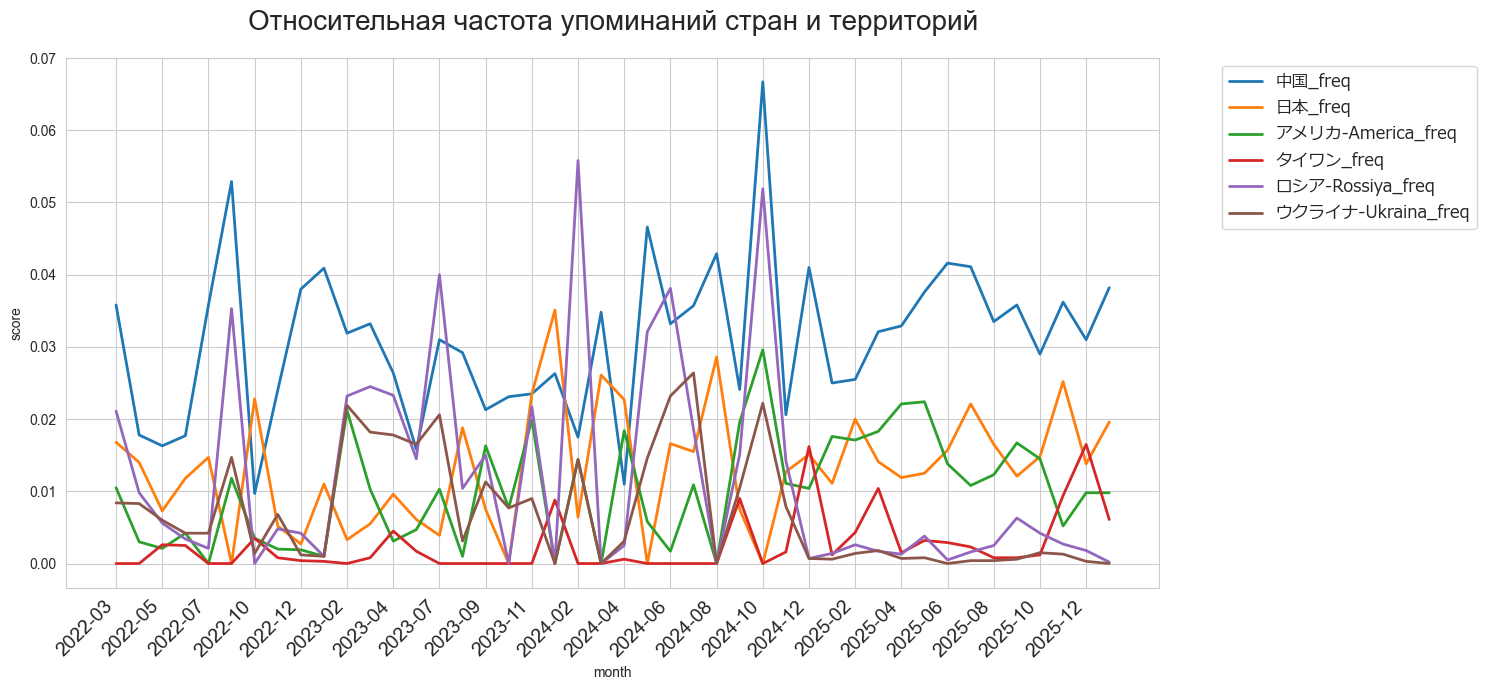

In [56]:
df_plot = df_countries.reset_index().melt(id_vars='month', var_name='country', value_name='score')
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_plot, x='month', y='score', hue='country', linewidth=2)
plt.title('Относительная частота упоминаний стран и территорий', fontsize=20, pad=20)
font_name = 'Meiryo'
font_prop = fm.FontProperties(family=font_name, size=12)
plt.legend(prop = font_prop, bbox_to_anchor=(1.05, 1), loc='upper left')
all_months = df_plot['month'].unique()
all_positions = np.arange(len(all_months))
selected_positions = all_positions[::2]
selected_labels = all_months[::2]
plt.xticks(selected_positions, selected_labels, rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.show()

In [57]:
df_countries.to_excel('countries by month.xlsx')

In [58]:
df_persons = word_dynamics (df_by_month, persons)
df_persons['Президент США_freq'] = df_persons['トランプ-trump_freq'] + df_persons['バイデン-Biden_freq']
df_persons = df_persons.iloc[:, -3:]

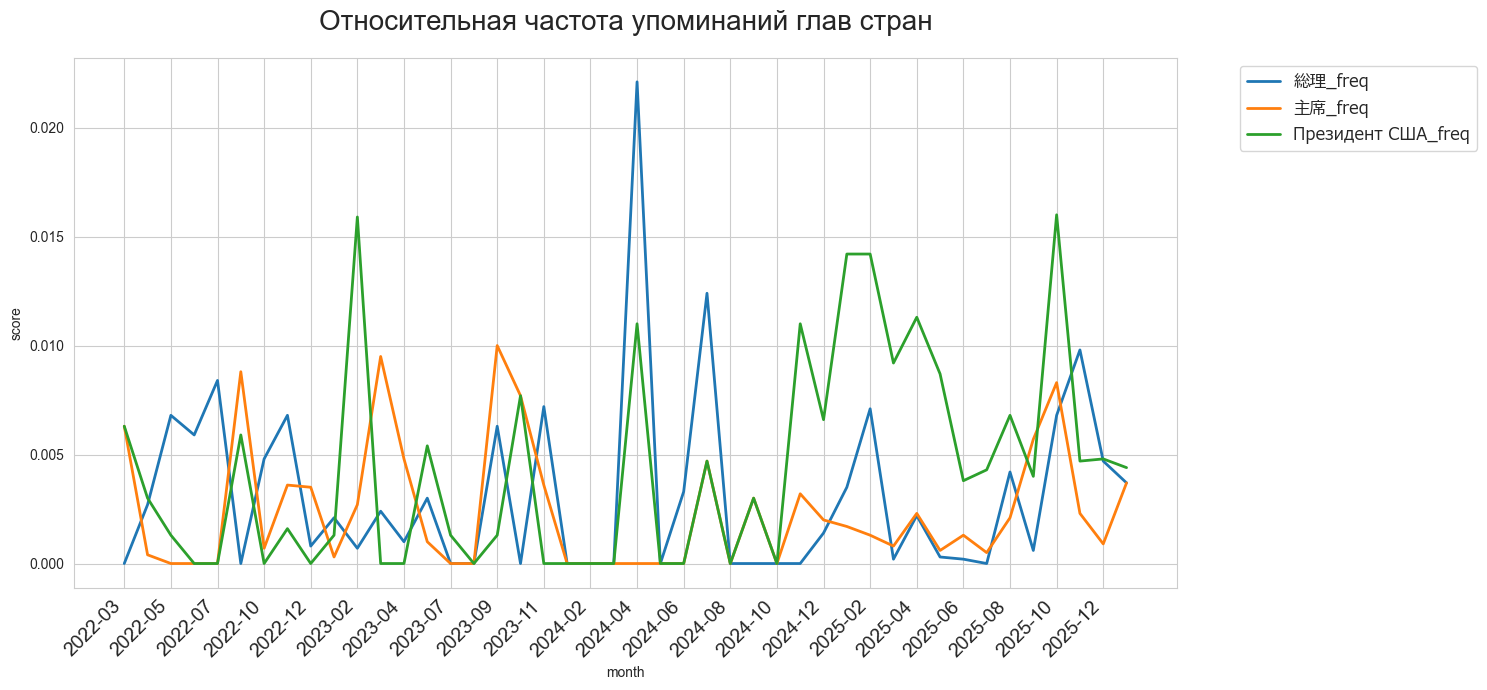

In [59]:
df_plot = df_persons.reset_index().melt(id_vars='month', var_name='person', value_name='score')
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_plot, x='month', y='score', hue='person', linewidth=2)
plt.title('Относительная частота упоминаний глав стран', fontsize=20, pad=20)
font_name = 'Meiryo'
font_prop = fm.FontProperties(family=font_name, size=12)
plt.legend(prop = font_prop, bbox_to_anchor=(1.05, 1), loc='upper left')
all_months = df_plot['month'].unique()
all_positions = np.arange(len(all_months))
selected_positions = all_positions[::2]
selected_labels = all_months[::2]
plt.xticks(selected_positions, selected_labels, rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.show()

In [60]:
df_economic = word_dynamics (df_by_month, economic)

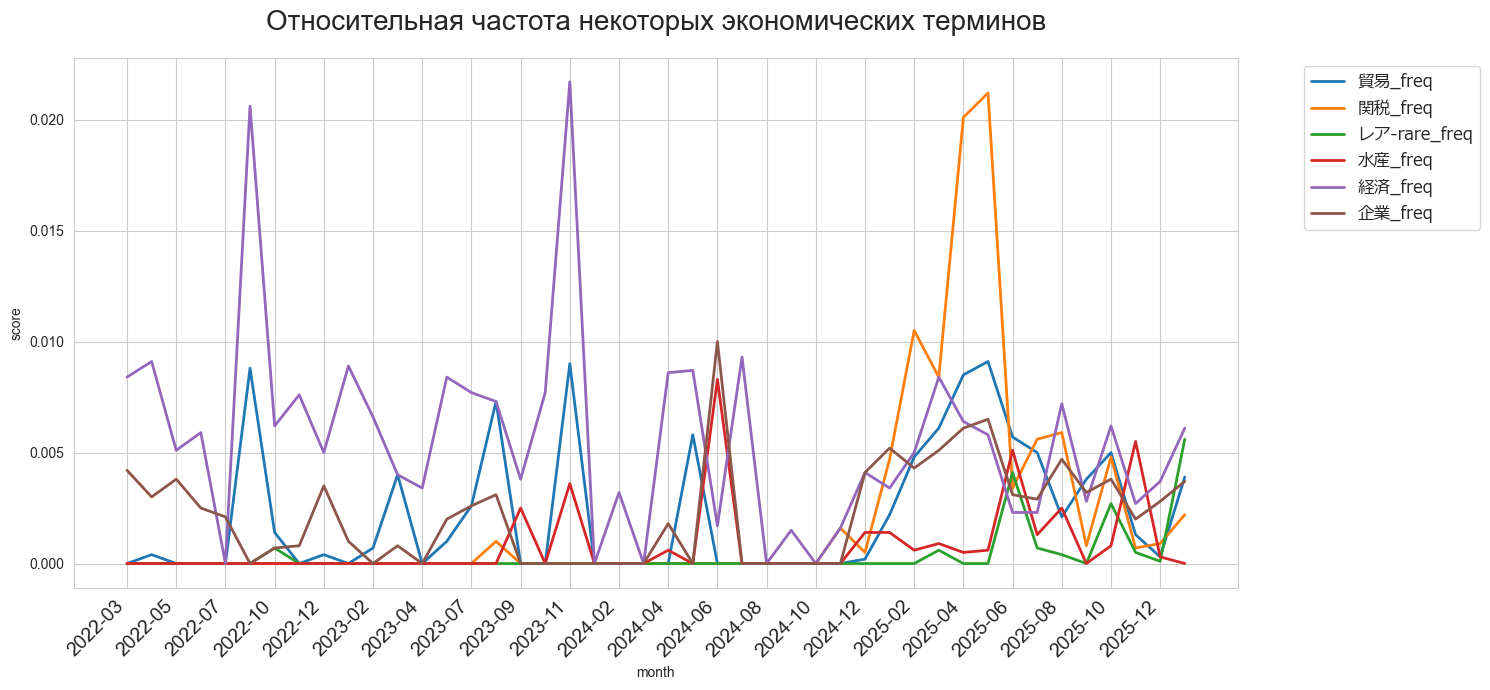

In [61]:
df_plot = df_economic.reset_index().melt(id_vars='month', var_name='economic terms', value_name='score')
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_plot, x='month', y='score', hue='economic terms', linewidth=2)
plt.title('Относительная частота некоторых экономических терминов', fontsize=20, pad=20)
font_name = 'Meiryo'
font_prop = fm.FontProperties(family=font_name, size=12)
plt.legend(prop = font_prop, bbox_to_anchor=(1.05, 1), loc='upper left')
all_months = df_plot['month'].unique()
all_positions = np.arange(len(all_months))
selected_positions = all_positions[::2]
selected_labels = all_months[::2]
plt.xticks(selected_positions, selected_labels, rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.show()

In [62]:
df_security = word_dynamics (df_by_month, security)

In [455]:
df_security.to_excel('security terms by month.xlsx')

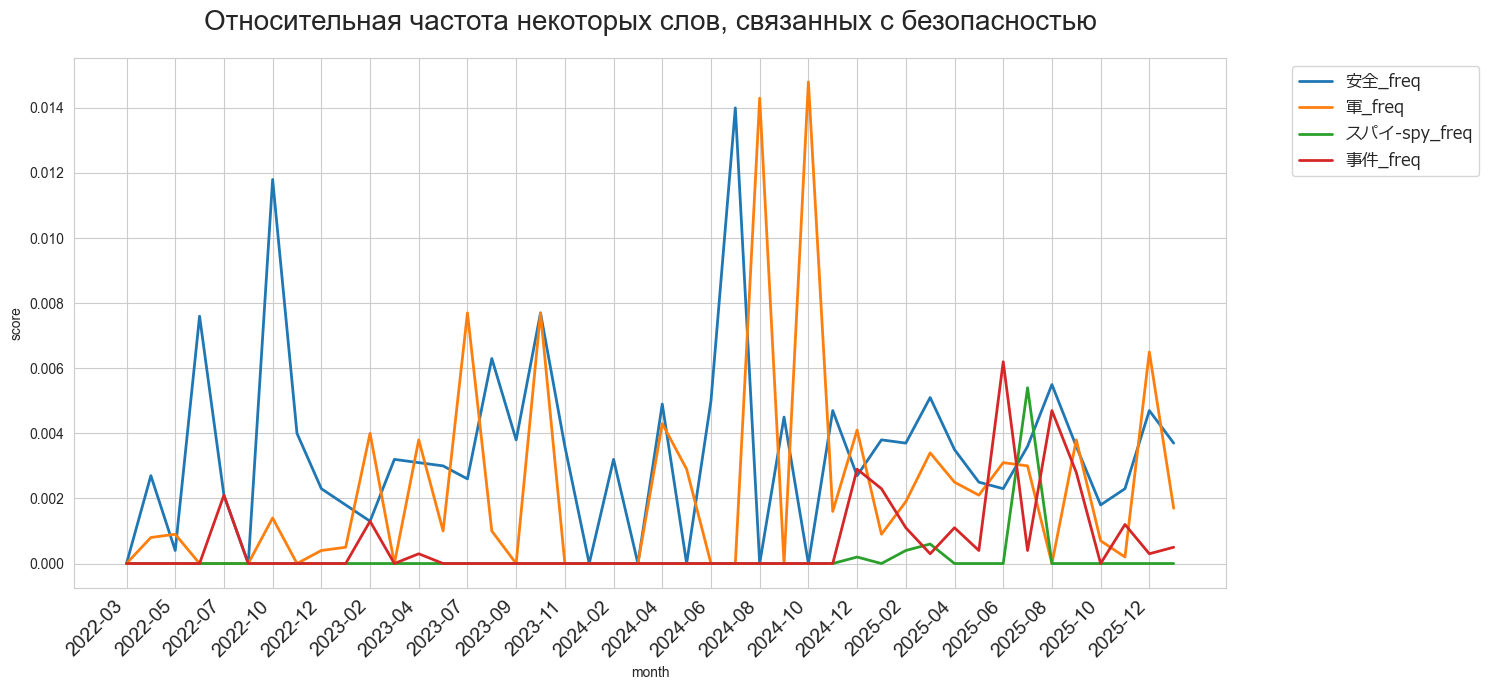

In [63]:
df_plot = df_security.reset_index().melt(id_vars='month', var_name='security terms', value_name='score')
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_plot, x='month', y='score', hue='security terms', linewidth=2)
plt.title('Относительная частота некоторых слов, связанных с безопасностью', fontsize=20, pad=20)
font_name = 'Meiryo'
font_prop = fm.FontProperties(family=font_name, size=12)
plt.legend(prop = font_prop, bbox_to_anchor=(1.05, 1), loc='upper left')
all_months = df_plot['month'].unique()
all_positions = np.arange(len(all_months))
selected_positions = all_positions[::2]
selected_labels = all_months[::2]
plt.xticks(selected_positions, selected_labels, rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.show()

In [64]:
df_corona = word_dynamics (df_by_month, corona)

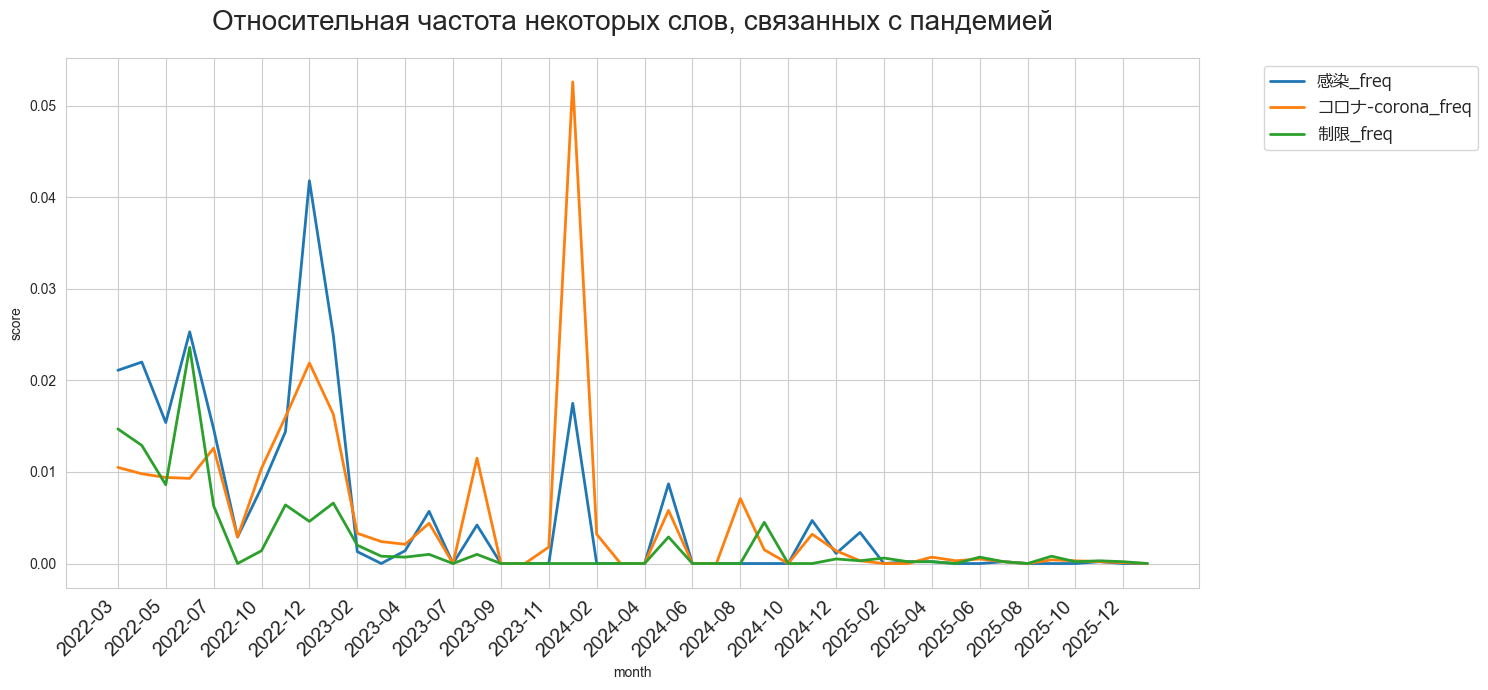

In [65]:
df_plot = df_corona.reset_index().melt(id_vars='month', var_name='corona words', value_name='score')
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_plot, x='month', y='score', hue='corona words', linewidth=2)
plt.title('Относительная частота некоторых слов, связанных с пандемией', fontsize=20, pad=20)
font_name = 'Meiryo'
font_prop = fm.FontProperties(family=font_name, size=12)
plt.legend(prop = font_prop, bbox_to_anchor=(1.05, 1), loc='upper left')
all_months = df_plot['month'].unique()
all_positions = np.arange(len(all_months))
selected_positions = all_positions[::2]
selected_labels = all_months[::2]
plt.xticks(selected_positions, selected_labels, rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.show()

In [66]:
df_mix = word_dynamics (df_by_month, mix)

In [456]:
df_mix.to_excel('various words by month.xlsx')

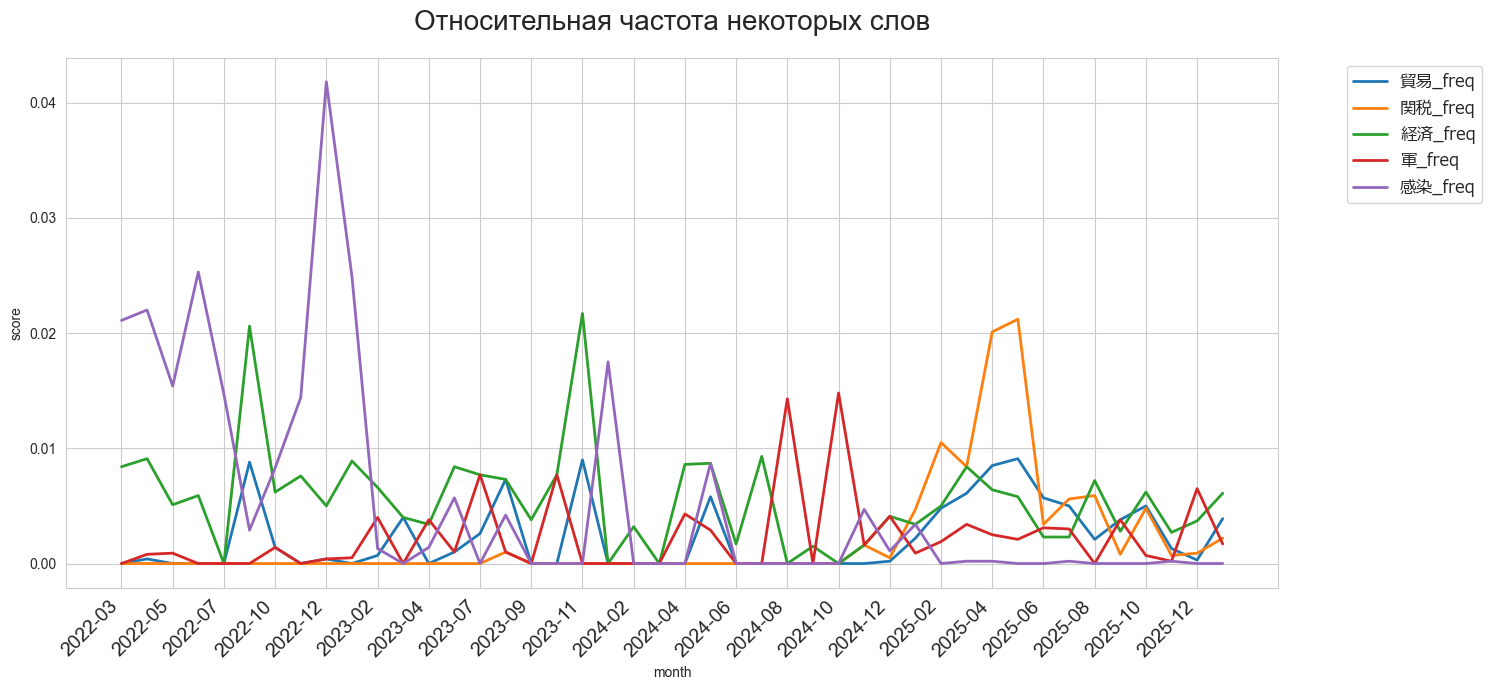

In [67]:
df_plot = df_mix.reset_index().melt(id_vars='month', var_name='words', value_name='score')
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_plot, x='month', y='score', hue='words', linewidth=2)
plt.title('Относительная частота некоторых слов', fontsize=20, pad=20)
font_name = 'Meiryo'
font_prop = fm.FontProperties(family=font_name, size=12)
plt.legend(prop = font_prop, bbox_to_anchor=(1.05, 1), loc='upper left')
all_months = df_plot['month'].unique()
all_positions = np.arange(len(all_months))
selected_positions = all_positions[::2]
selected_labels = all_months[::2]
plt.xticks(selected_positions, selected_labels, rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
collocations = [('外出', '制限'), ('感染', '拡大'), ('ロシア-Rossiya', 'ウクライナ-Ukraina'), ('中国', '軍'), ('貿易', '摩擦')]
#ограничения на выход из дома, расширение заболеваемости, российско-украинский, китайская армия, торговые трения

In [69]:
df_col = df_by_month.loc[:, ['tokens']]
for i in collocations:
    df_col[f'{i}_freq'] = df_col['tokens'].apply(lambda x: BigramCollocationFinder.from_words(x).ngram_fd[i]/BigramCollocationFinder.from_words(x).N).round(4)
df_col = df_col.iloc[:, -len(collocations):]
df_col

,"('外出', '制限')_freq","('感染', '拡大')_freq","('ロシア-Rossiya', 'ウクライナ-Ukraina')_freq","('中国', '軍')_freq","('貿易', '摩擦')_freq"
month,,,,,
2022-03,0.0147,0.0063,0.0084,0.0000,0.0000
2022-04,0.0110,0.0061,0.0030,0.0004,0.0000
2022-05,0.0056,0.0047,0.0017,0.0000,0.0000
2022-06,0.0152,0.0042,0.0008,0.0000,0.0000
2022-07,0.0042,0.0084,0.0021,0.0000,0.0000
2022-09,0.0000,0.0000,0.0059,0.0000,0.0000
2022-10,0.0000,0.0035,0.0000,0.0000,0.0000
2022-11,0.0012,0.0052,0.0044,0.0000,0.0000
2022-12,0.0008,0.0081,0.0000,0.0000,0.0000


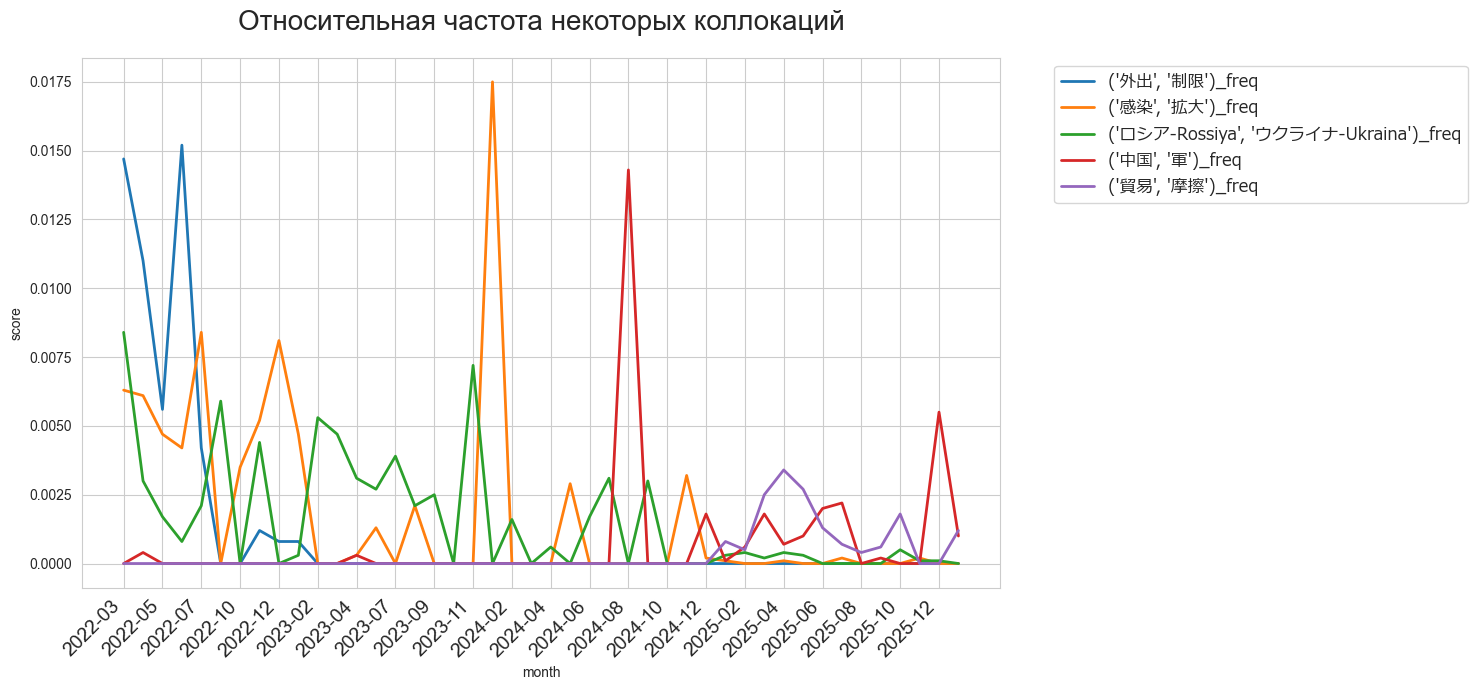

In [70]:
df_plot = df_col.reset_index().melt(id_vars='month', var_name='collocations', value_name='score')
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))
sns.lineplot(data=df_plot, x='month', y='score', hue='collocations', linewidth=2)
plt.title('Относительная частота некоторых коллокаций', fontsize=20, pad=20)
font_name = 'Meiryo'
font_prop = fm.FontProperties(family=font_name, size=12)
plt.legend(prop = font_prop, bbox_to_anchor=(1.05, 1), loc='upper left')
all_months = df_plot['month'].unique()
all_positions = np.arange(len(all_months))
selected_positions = all_positions[::2]
selected_labels = all_months[::2]
plt.xticks(selected_positions, selected_labels, rotation=45, ha='right', fontsize=14)
plt.tight_layout()
plt.show()